## Visualizations

In [1]:
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd

In [6]:
df = pd.read_csv("bofedales-clusters7.csv")
df.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1, inplace=True)

In [7]:
df.head(1)

,Area_m2,AUC,pct_prot,elev_mean_,elev_std_m,n_wells,Ground Water Rights 1966-01-01,Ground Water Rights 1967-01-01,Ground Water Rights 1968-01-01,Ground Water Rights 1969-01-01,...,NDWI 2019-06,NDWI 2019-07,NDWI 2019-08,NDWI 2019-09,NDWI 2019-10,NDWI 2019-11,NDWI 2019-12,cluster,cluster_name,cluster_abr
0,6300,86.769539,0.0,4162.714286,3.953815,0.0,0.0,0.0,0.0,0.0,...,0.019181,0.023405,0.015355,-0.000504,0.004056,0.014678,0.010436,0,Colchane y Pica Este,CPE


In [9]:
cluster_palette = {
    "GL":   "#693B11", # Brown
    "CPLN": "#F38D14", # Orange
    "PLSRV":"#9863D0", # Purple
    "PP":   "#C81A00", # Red
    "CPE":  "#3973ac", # Blue
    "PT":   "#339933", # Green
    "OC":   "#ff99dd", # Pink
}

### Helper Functions

In [11]:
def create_line_graph(
        var, unit=None,
        bottom_lim=-10, top_lim=1000, zoom=False,
        frmat="%Y-%m-%d",
        lines=None,
        show_cluster_legend=True,
        show_line_legend=True
    ):
    global df
    lines = lines or []

    var_cols = [c for c in df.columns if c.startswith(f"{var}")]
    var_df = df[var_cols + ["cluster_abr"]].copy()

    var_df.columns = (
        pd.to_datetime([c.replace(f"{var} ", "") for c in var_cols], format=frmat, errors="raise")
        .tolist() + ["cluster_abr"]
    )

    cluster_means_var = var_df.groupby("cluster_abr").mean()

    temp = cluster_means_var.T

    temp.index = pd.to_datetime(temp.index, errors="raise")
    cluster_means_annual = temp.resample("YE").mean().T

    fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

    for cid in cluster_means_annual.index:           # ← cid == "CPE", "GL", …
        ax.plot(cluster_means_annual.columns.year,
                cluster_means_annual.loc[cid],
                linewidth=2,
                color=cluster_palette[cid],          # ← use your palette
                label=f"Cluster {cid}")
        
    ax.set_xlabel("Year")
    ax.set_ylabel(f"Average {var}" + (f" ({unit})" if unit else ""))
    ax.set_title(f"Average {var} by Cluster")
    ax.grid(alpha=0.3)

    line_handles = []
    for ln in lines:
        val = ln["value"]
        orient = ln["orientation"]
        label = ln["label"]
        color = ln.get("color", "red")
        style = ln.get("style", "--")
        width = ln.get("width", 2)

        if orient.lower().startswith("h"):
            ax.axhline(val, color=color, linestyle=style, linewidth=width)
        else:
            ax.axvline(val, color=color, linestyle=style, linewidth=width)

        line_handles.append(
            mlines.Line2D([], [], color=color, linestyle=style,
                          linewidth=width, label=label)
        )

    need_margin = (
        show_cluster_legend or (show_line_legend and line_handles)
    )

    if show_line_legend and line_handles:
        line_leg = ax.legend(handles=line_handles,
                             loc="upper left",
                             bbox_to_anchor=(1.02, 0.95),
                             frameon=False)
        ax.add_artist(line_leg)
    
    if show_cluster_legend:
        cluster_handles = [
            mlines.Line2D([], [], color=cluster_palette[abbr],
                          linewidth=2, label=f"Cluster {abbr}")
            for abbr in ["CPE","CPLN","GL","OC","PLSRV","PP","PT"]  # order you like
        ]
        ax.legend(handles=cluster_handles, title="Cluster ID",
                  loc="center left", bbox_to_anchor=(1.02, 0.50),
                  frameon=False)
    
    if zoom:
        ax.set_ylim(bottom_lim, top_lim)

    plt.show()


In [12]:
def calc_std(var, frmat="%Y-%m-%d"):
    global df
    var_cols = [c for c in df.columns if c.startswith(f"{var}")]
    var_df = df[var_cols + ["cluster"]].copy()
    date_strings = [c.replace(f"{var} ", "") for c in var_cols]
    dates = pd.to_datetime(date_strings, format=frmat)
    var_df.columns = list(dates) + ["cluster"]
    
    cluster_std = var_df.groupby("cluster").std()
    
    cluster_std.columns = pd.to_datetime(cluster_std.columns, format="%Y-%m-%d")
    
    cluster_std_annual = (
        cluster_std.T
                     .resample("YE")
                     .mean()
                     .T
    )
    avg_std_per_cluster = cluster_std_annual.mean(axis=1)
    return avg_std_per_cluster

### By feature
#### Precipitation

In [13]:
calc_std("Precipitation")

cluster
0    3.935933
1    1.601056
2    0.000000
3    2.921836
4    0.000000
5    1.739541
6    1.537173
dtype: float64

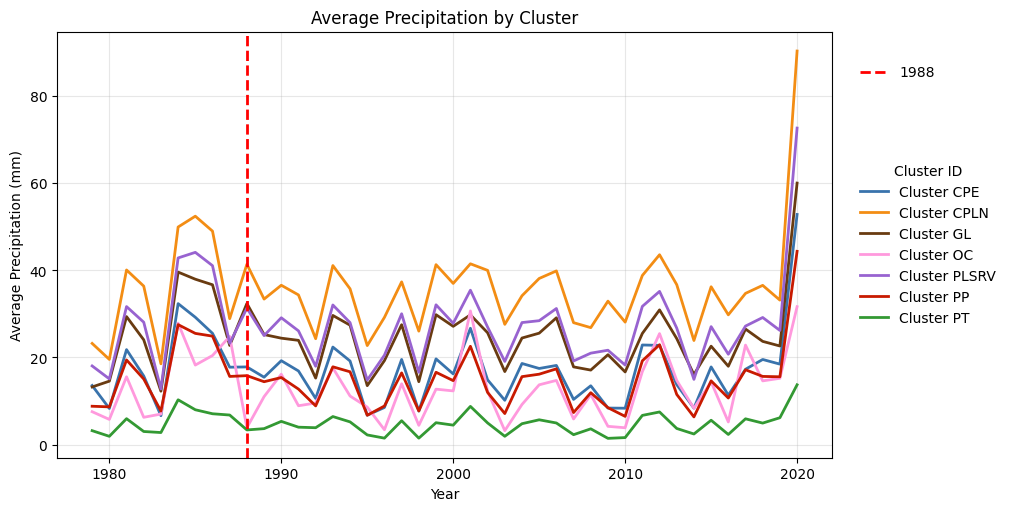

In [14]:
create_line_graph("Precipitation", "mm", lines=[{
     "value": 1988,
     "orientation": "v",
     "label": "1988",
     "color": "red"
}])

In [15]:
calc_std("Ground Water Rights")

cluster
0    190.06412
1      0.00000
2      0.00000
3     26.36283
4      0.00000
5      0.00000
6      0.00000
dtype: float64

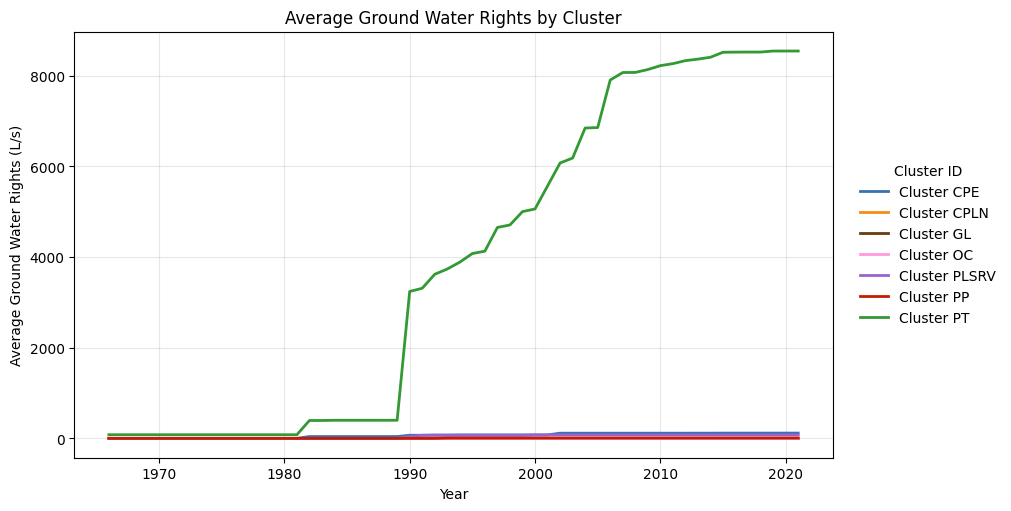

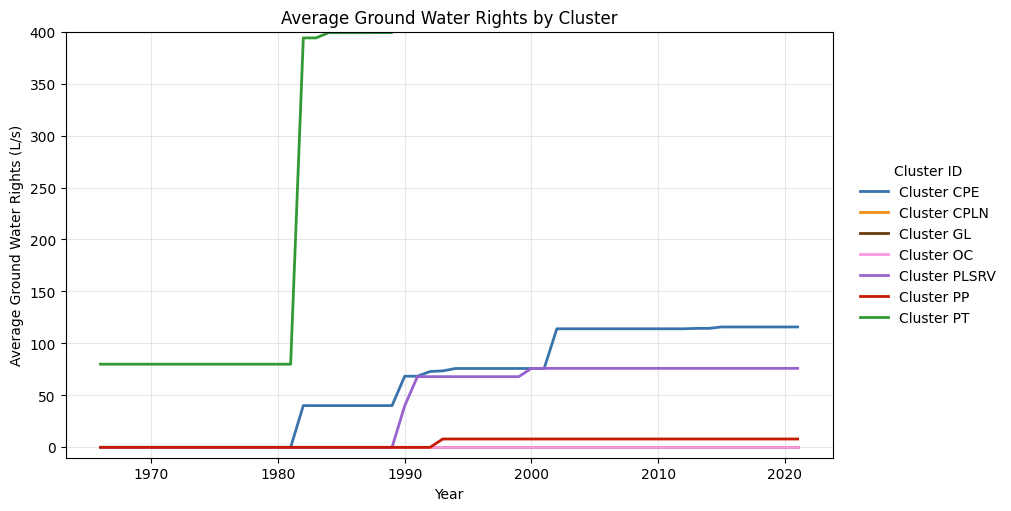

In [16]:
create_line_graph("Ground Water Rights", "L/s")
create_line_graph("Ground Water Rights", "L/s", zoom=True, top_lim=400)

In [17]:
calc_std("Surface Water Rights")

cluster
0      98.041081
1    1788.817674
2       0.000000
3      34.605749
4       0.000000
5      71.523764
6      30.709763
dtype: float64

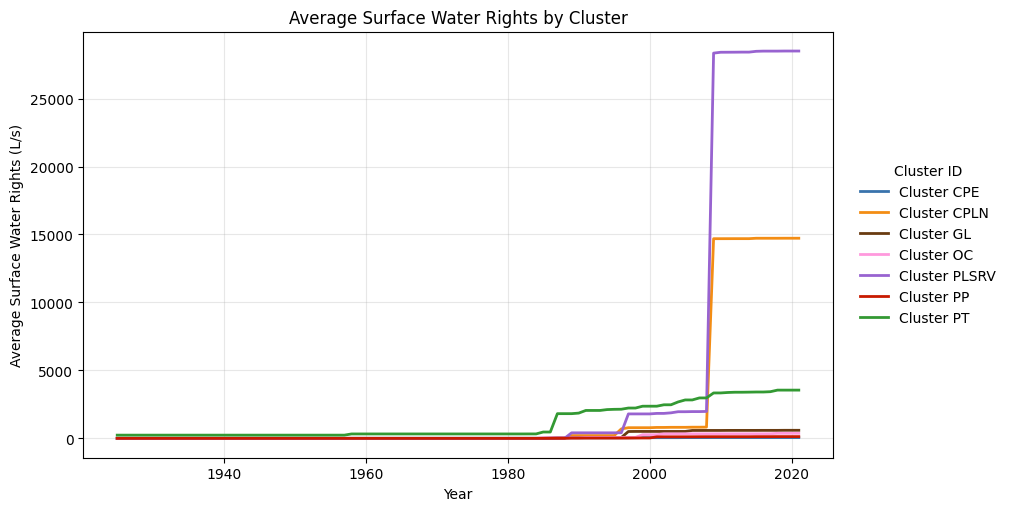

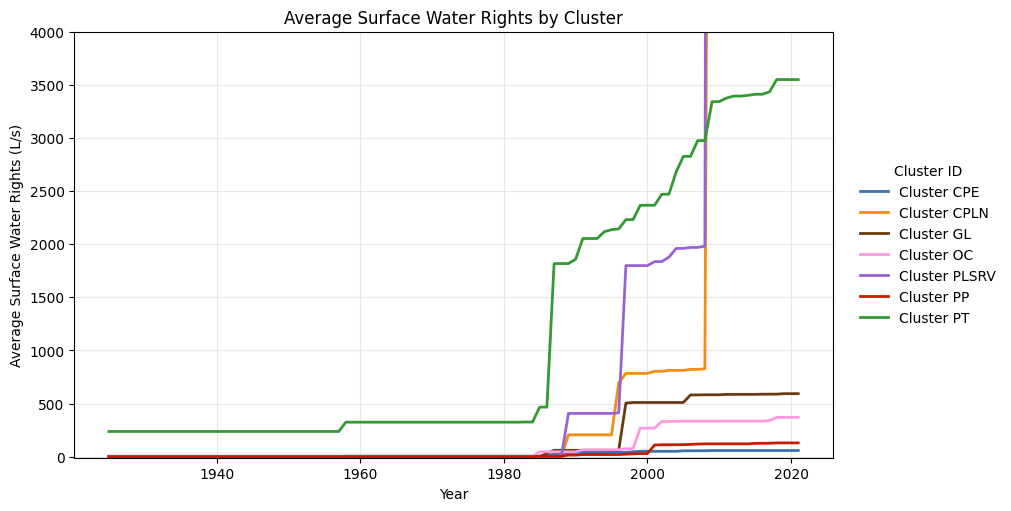

In [18]:
create_line_graph("Surface Water Rights", "L/s")
create_line_graph("Surface Water Rights", "L/s", zoom=True, top_lim=4000)

In [19]:
calc_std("PET")

cluster
0    3.713761
1    1.208757
2    0.000000
3    5.041731
4    0.000000
5    1.152062
6    4.929999
dtype: float64

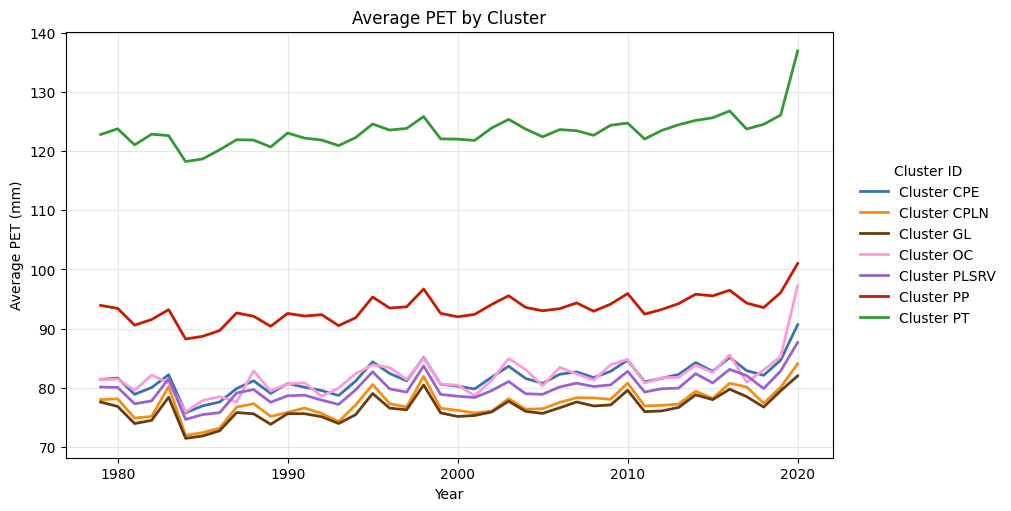

In [20]:
create_line_graph("PET", "mm")

In [21]:
print(f"Temp Min: {calc_std("Temp Min")}")
print(f"Temp Max: {calc_std("Temp Max")}")

Temp Min: cluster
0    1.230031
1    0.309451
2    0.000000
3    1.421959
4    0.000000
5    1.067316
6    0.423054
dtype: float64
Temp Max: cluster
0    0.914520
1    0.302583
2    0.000000
3    1.322048
4    0.000000
5    0.532971
6    1.121170
dtype: float64


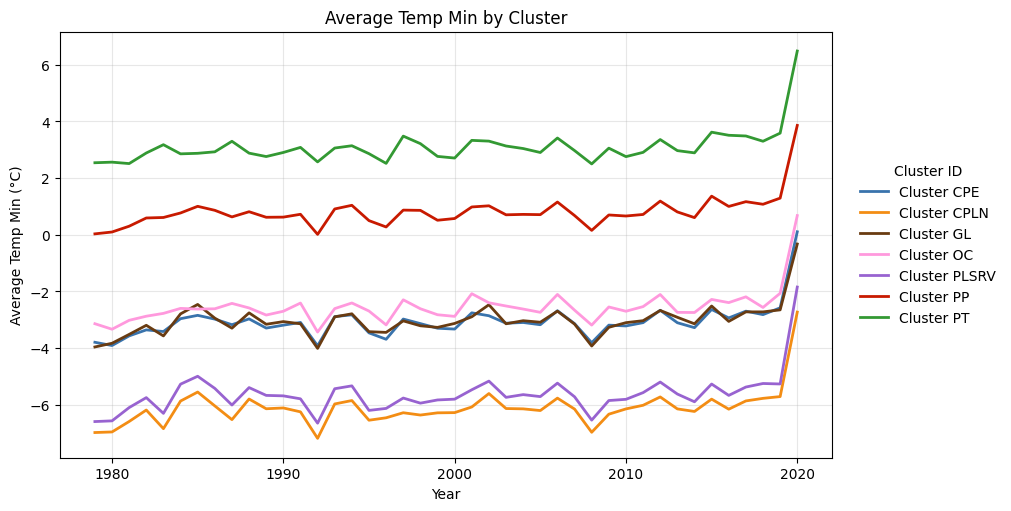

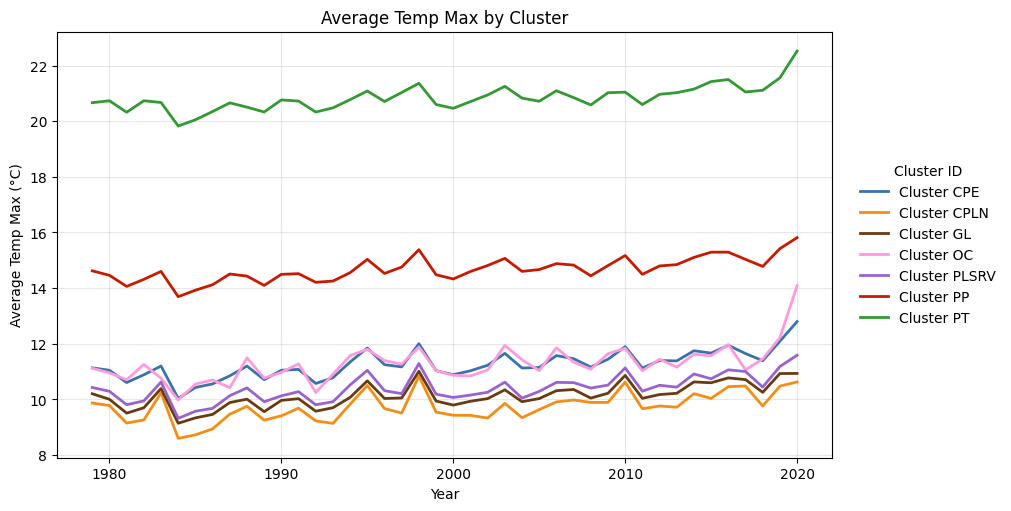

In [22]:
create_line_graph("Temp Min", "°C")
create_line_graph("Temp Max", "°C")

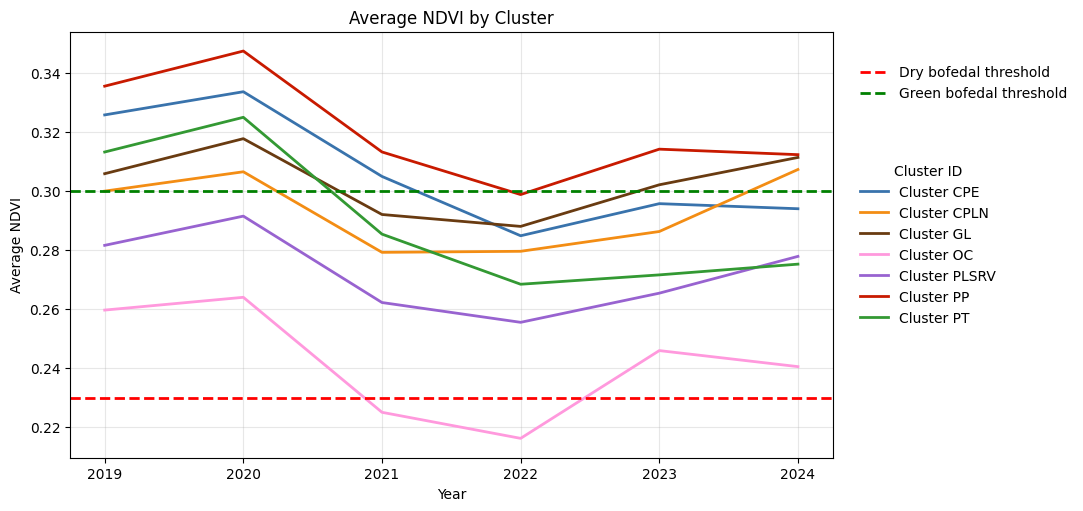

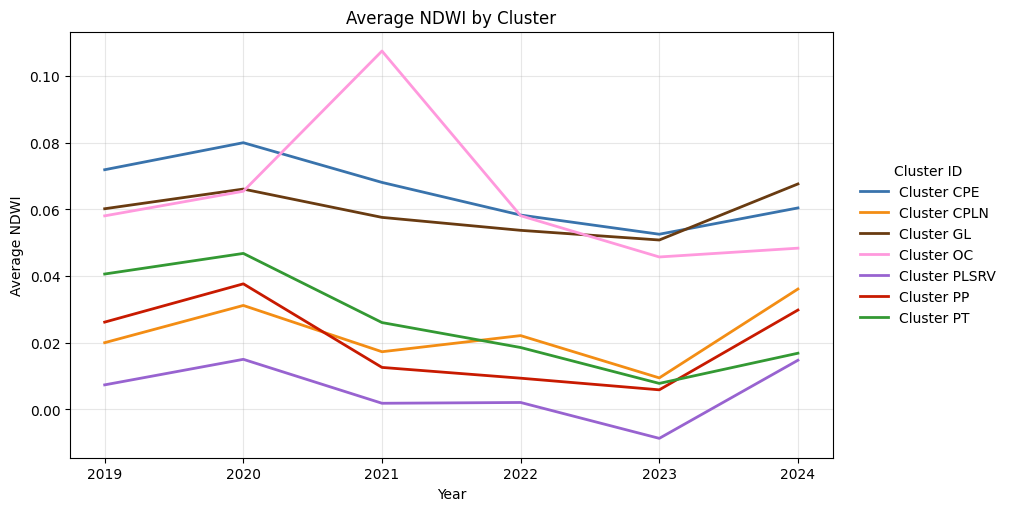

In [23]:
create_line_graph("NDVI", frmat="%Y-%m", lines=[{
     "value": 0.23,
     "orientation": "h",
     "label": "Dry bofedal threshold",
     "color": "red"
},
{
     "value": 0.3,
     "orientation": "h",
     "label": "Green bofedal threshold",
     "color": "green"
}])
create_line_graph("NDWI", frmat="%Y-%m")

In [24]:
calc_std("NDVI", frmat="%Y-%m")

cluster
0    0.082698
1    0.084533
2    0.069451
3    0.078628
4    0.069259
5    0.079238
6    0.079405
dtype: float64

In [25]:
calc_std("NDWI", frmat="%Y-%m")

cluster
0    0.084409
1    0.084534
2    0.084904
3    0.076970
4    0.069909
5    0.089191
6    0.108858
dtype: float64

In [27]:
# fig, ax = plt.subplots(figsize=(8, 5))

# ax.bar(
#     cluster_means.index.astype(str),

#     cluster_means["Area_m2"]
# )

# ax.set_xlabel("Cluster ID")
# ax.set_ylabel("Average Area (m²)")
# ax.set_title("Average Bofedal Area by Cluster")
# plt.xticks(rotation=0)
# plt.tight_layout()
# plt.show()

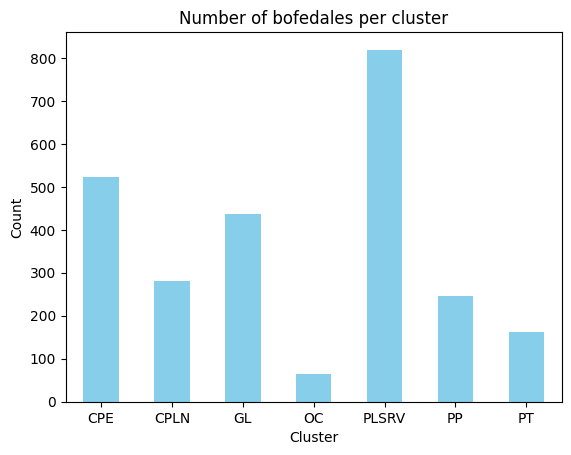

In [131]:
df["cluster_abr"].value_counts().sort_index().plot.bar(color='skyblue')

plt.xlabel("Cluster"); plt.ylabel("Count")
plt.title("Number of bofedales per cluster")
plt.xticks(rotation=0)

plt.show()

In [134]:
patterns = [
    "NDVI", "NDWI",
    "Ground Water Rights", "Surface Water Rights",
    "PET", "Precipitation",
    "Temp Min", "Temp Max"
]

cols_to_keep = [col for col in df.columns
                if not any(pat in col for pat in patterns)]

cols_to_keep

['Area_m2',
 'AUC',
 'pct_prot',
 'elev_mean_',
 'elev_std_m',
 'n_wells',
 'lon',
 'lat',
 'cluster',
 'precip_anom_1988',
 'cluster_name',
 'cluster_abr']

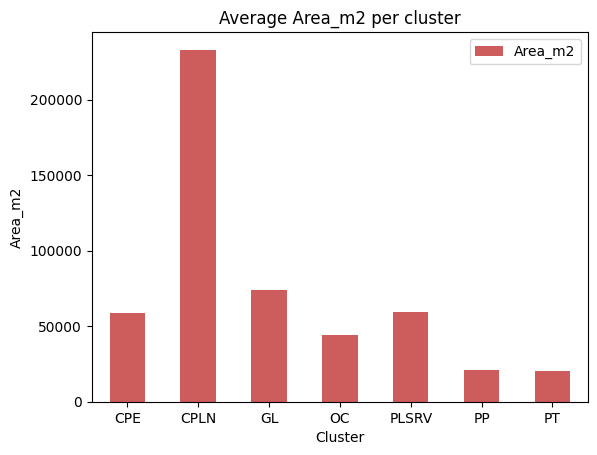

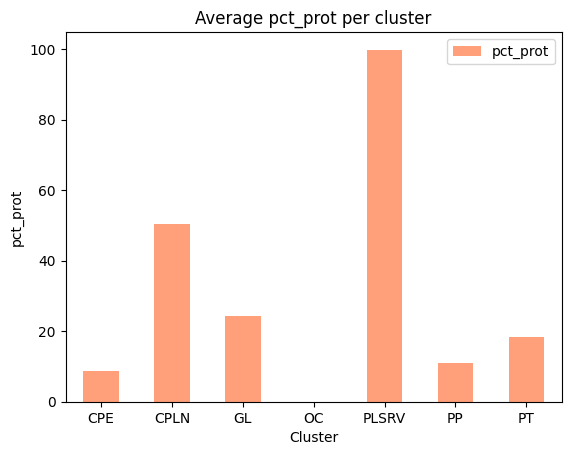

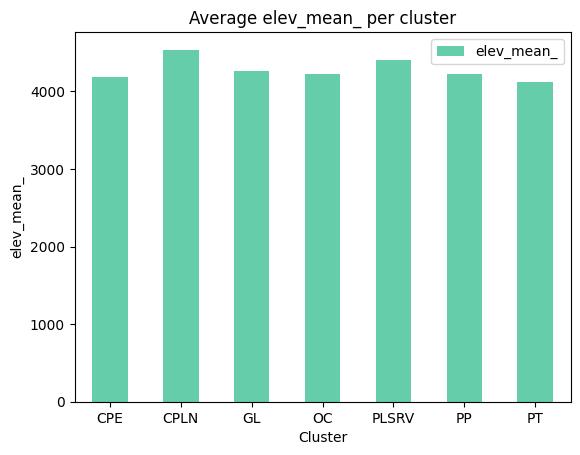

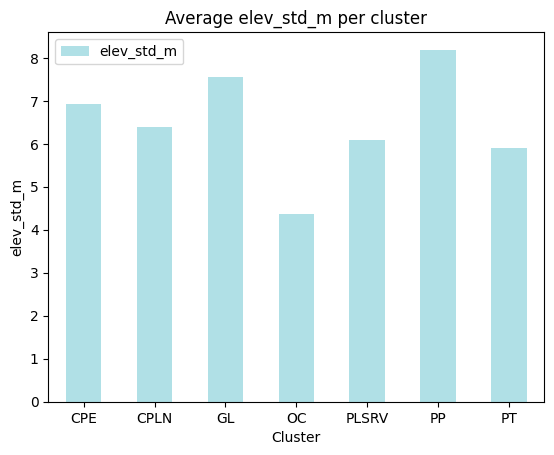

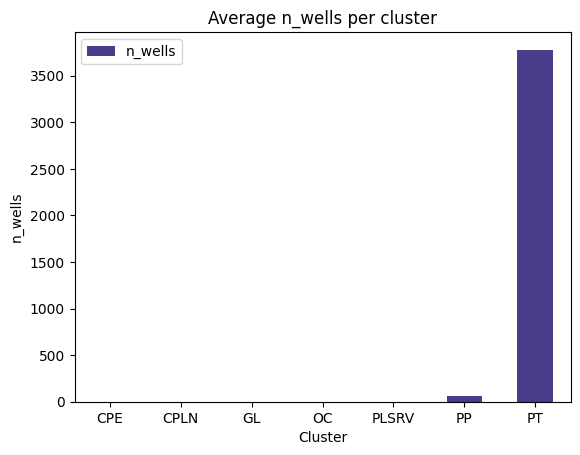

In [140]:
colors = ["indianred", "lightsalmon", "mediumaquamarine", "powderblue","darkslateblue"]
color_index = 0
for variable in ['Area_m2','pct_prot','elev_mean_','elev_std_m','n_wells']:
    df.groupby("cluster_abr").agg({variable: "mean"}).plot.bar(color=colors[color_index])
    
    plt.xlabel("Cluster"); plt.ylabel(variable)
    plt.title(f"Average {variable} per cluster")
    plt.xticks(rotation=0)
    
    plt.show()
    color_index += 1